<font size = "5"> **Chapter 3: [Imaging](CH3_00-Imaging.ipynb)** </font>


<hr style="height:1px;border-top:4px solid #FF8200" />



# Contrast Transfer Function


[Download](https://raw.githubusercontent.com/gduscher/MSE672-Introduction-to-TEM/main/Imaging/CH3_03-CTF.ipynb)


[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/gduscher/MSE672-Introduction-to-TEM/blob/main//Imaging/CH3_03-CTF.ipynb)

part of 

<font size = "5"> **[MSE672:  Introduction to Transmission Electron Microscopy](../_MSE672_Intro_TEM.ipynb)**</font>


**Spring 2024**
<table style="margin-right:auto;margin-left:0px">
  <tr>
    <td>Gerd Duscher </td>
    <td>Khalid Hattar</td>
  </tr>
  <tr>
    <td>Microscopy Facilities</td> 
    <td> Tennessee Ion Beam Materials Laboratory </td>
  </tr>
  
  <tr>
    <td>Materials Science & Engineering</td>
    <td> Nuclear Engineering</td>
  </tr>
  <tr>
    <td>Institute of Advanced Materials & Manufacturing</td>
    <td> </td>
  </tr>
  <tr>
    <td colspan="2"><center> The University of Tennessee, Knoxville</center> </td>
  </tr>
</table>

Background and methods to analysis and quantification of data acquired with transmission electron microscopes.




## Load important packages

### Check Installed Packages


In [2]:
import sys
import importlib.metadata
def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = importlib.metadata.version(package_name)
    except importlib.metadata.PackageNotFoundError:
        version = '-1'
    return version

if test_package('pyTEMlib') < '0.2024.2.3':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install  --upgrade pyTEMlib -q

print('done')

done


### Load Packages
We will use 
- numpy and matplotlib (installed with magic comand **%pylab**.)
- some more plotting functions for circle and tables
- The pyTEMlib kinematic scattering librarty is only used to determine the wavelength.

In [1]:
%matplotlib  widget
import matplotlib.pyplot as plt
import numpy as np
import sys
if 'google.colab' in sys.modules:
    from google.colab import output
    output.enable_custom_widget_manager()


# Multidimensional Image library
import scipy.ndimage as ndimage

# Some additional plotting libraries
from matplotlib.patches import Circle
from IPython.display import HTML, display
    
# Import libraries from pyTEMlib
import pyTEMlib
import pyTEMlib.animation
import pyTEMlib.kinematic_scattering as ks         # Kinematic sCattering Library

# it is a good idea to show the version numbers at this point for archiving reasons.
print('pyTEM version: ',pyTEMlib.__version__)
__notebook_version__ = '2022_03_23'

You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
You don't have gwyfile installed.     If you wish to open .gwy files, you will need to      install it (pip install gwyfile) before attempting.
Symmetry functions of spglib enabled
Using kinematic_scattering library version {_version_ }  by G.Duscher
pyTEM version:  0.2024.02.2


## Lens Aberrations

This theoretical resolution of the de Broglie Wavelength as discussed in the [Resolution Notebook](./CH3_01-Resolution.ipynb) is not achieved so far, because electro-magnetic lenses are as bad as
* bottom of champagne bottle (Europe)
* bottom of coke bottle (US)

> **We need to look into the aberrations of lenses if we want to understand resolution in the TEM**

### Schematic of Aberration

An ideal lens converges all rays going through the lens parallel to the optical axis in the focal point. 

The wavefront is laying on a circle, meaning all rays are perpendicular to the tagent of a sphere centered at the focal point. (press ideal rays below)

Aberrated rays of a certain distance (and angle in cylindrical coordinates) to the optical axis cut the optic axis at a point which is not the focal point and lay on a sphere with the center at that point. (press aberrated rays in figure below to visualize)

In the case of spherical aberration the point of rays cutting the optical axis with distance
will move more and more away from the focal point. The projection of that aberration is an ellipse. (as shown below with aberration wavefront pressed)

The difference between the ideal (spherical) wavefront and the aberrated one is directly related  to the aberration function.( which is schematically visualized if aberration function is pressed below)

Box(children=(ToggleButton(value=False, description='ideal rays'), ToggleButton(value=False, description='aber…

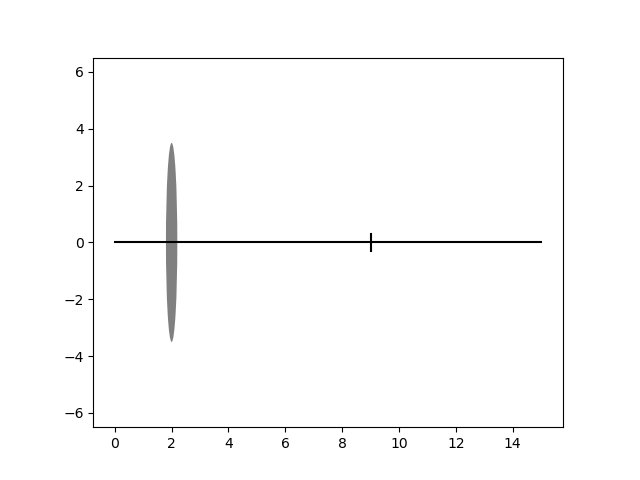

In [2]:
view_i = pyTEMlib.animation.InteractiveAberration()

### Notation of Aberrations
The notations of the coefficients $C_{m,n}$ of the aberration function $\chi$ is defined according to [Krivanek et al.](https://doi.org/10.1016/S0304-3991(99)00013-3):

|Notation | Order of ray aberr. |Order of wave aberr.| Name | Symmetry|
|---|---|---|---|---|	
|C$_{01A}$ | 0 | 1 | Probe shift in x direction | 1-fold|
|C$_{01B}$ | 0 | 1 | Probe shift in y direction | 1-fold|
|C$_{1}$   | 1 | 2 | Defocus                    | Rotational|
|C$_{12}$  | 1 | 2 | Astigmatism                | 2-fold|
|C$_{21}$  | 2 | 3 | Coma                       | 1-fold|
|C$_{23}$  | 2 | 3 | 3-fold astigmatism         | 3-fold|
|C$_{3}$   | 3 | 4 | Spherical aberration (C$_s$)| Rotational|
|C$_{32}$  | 3 | 4 | 2--fold astig of C$_s$     | 3-fold|
|C$_{34}$  | 3 | 4 | 4--fold astig of C$_s$     | 3-fold|

I am using that notation because the Nion dedicated STEMs use this notation.

With the above notation the aberration function is expressed in spherical coordinates as:
$$
\chi(\theta, \phi) 
= \{ \theta [ C_{01A}\cos(\phi)+C_{01B}\sin(\phi)]\\
+  \frac{\theta^2}{2}[C_1+C_{12A}\cos(2\phi)+C_{12B}\sin(2\phi)]+\nonumber \\
+ \frac{\theta^3}{3}[C_{21A}\cos(\phi)+C_{21B}\sin(\phi)+
C_{23A}\cos(3\phi)+C_{23B}\sin(3\phi)]+\nonumber \\
+ \frac{\theta^4}{4}[C_3+C_{32A}\cos(2\phi)+C_{32B}\sin(2\phi)+
C_{34A}\cos(4\phi)+C_{34B}\sin(4\phi)]+ \nonumber\\
+ ...\}\nonumber
$$
which is equivalent to:

$$
\chi(\theta, \phi) = \sum_m \theta^{m+1} *\frac{1}{m+1} * \sum_{n} C_{m,n,a}  \cos(n*\phi) + C_{m,n,b} \sin(n*\phi) 
$$

> you notice that $m$ is the order of aberration +1

### Aberrations of a (Non-Corrected) TEM

We set typical values for our TEM (Zeiss Libbra 200MC)


In [3]:
acceleration_voltage_V = 200*1e3 # Microscope voltage in V
C_s=2.2 # Spherical abberation coefficient in mm
defocus = -90 # Microscope defocus in nm
C_c=2.0 # Chromatic abberation coefficient in mm

## Contrast Transfer Function

For an uncorrected microscope the defocus $\Delta f$ and the spherical aberration $C_s = C_{30}$ are the resolution limiting parameter. The aberration function reduces to:


$$
\chi(\theta, \phi) = \frac{\theta^4}{4} C_3  + \frac{\theta^2}{2}C_1 $$
which is in carthesian coordinates 
$$\chi(k)=\frac{\pi}{2}C_s\lambda^3k^4-\pi \Delta f \lambda k^2$$


Incidentily, these aberrations are also independent of the azimutal angle and are isotrope in that direction.

The deBrouglie wave length  of the electrons $\lambda$ is calculated from the acceleration voltage as in notebook 
[The Electron](../Diffraction/CH2_01-Electron.ipynb)

The functions that tells us what spatial frequencies are transfered from  object to  image is called the 
**Contrast Transfer Function** (CTF).

$$CTF(k)=A(k)E(k)\sin(\chi(k))$$

With 
- $A$: objective aperture function; 
- $E$: envelope or damping function; 
- $\chi$ aberration function.

The **sin** function in above equation points to the oscillatory nature of the contrast transfer function, which is the worst possible behavior for a transfer functions. Some spatial frequencies are transfered with positive intensities, with others negative intensities and some even not at all. This is as far away from an ideally square transfer function as imaginable.   

To mitigate this problem, one aims for a rather flat aberration function for as long a range of spatial frequency as possible: 
The function $\sin(\chi)$ is flat if  $\frac{d\chi}{du}$ is zero.

$$\frac{d \chi(k)}{dk} = 2 \pi \Delta f \lambda k + 2 \pi C_{s} \lambda^3  k^3$$

We set the left term to zero to get the flat portion and get:

$$0 =  \Delta f  +  C_{s} \lambda^2  k^2$$

When $\chi $  is $-120^{\rm o}$ (or $-2\pi/3$) we get:

$$-\frac{2}{3}\pi = \pi \Delta f \lambda k^2 + \frac{1}{2} \pi C_{s} \lambda^3  k^4$$




##  Scherzer Focus
Combining the two equations gives a certain defocus value: the Scherzer focus $\Delta f_{Sch}$:

$$ \Delta f_{Sch}  =  -\sqrt{\frac{4}{3}C_{s} \lambda} = -1.2 \sqrt{C_{s} \lambda}$$

In [4]:
acceleration_voltage = 200*1e3  # microscope acceleration voltage in V
C_s = 2.2  # spherical abberation coefficient in mm

In [5]:
def calculate_scherzer(wavelength, C_s):
    """
    Calculate the Scherzer defocus. 
    
    Input:
    C_s: float - spherical aberration in mm (convention) will internally be scaled to Angstrom
    wavelength: float - wavelength in Angstrom
    order: int - optional the order of the Scherzer defocus
    
    Output:
    scherzer_defocus: float - Scherzer defocus in Angstrom
    """
    C_s = C_s * 1e7  # now in Angstrom
    scherzer_defocus = -np.sqrt(3/2 * C_s * wavelength)  # in nm    
    return scherzer_defocus

wavelength = ks.get_wavelength(acceleration_voltage) # in nm

scherzer =calculate_scherzer(wavelength, C_s)

print(f'Scherzer defocus is {scherzer/10:.1f} nm')

Scherzer defocus is -91.0 nm


### Higher Order Scherzer Defoci



Often the dimensionless form of the aberration function $\chi(k)$ is used where we substitute 

$$
K = k\left( C_s \lambda^3 \right)^{\frac{1}{4}}\\
$$
$$
D = \frac{\Delta f}{\sqrt{C_s \lambda}}\\
$$

into the aberration function $\chi(k)$:

$$\chi(k)=\frac{\pi}{2}C_s\lambda^3k^4-\pi \Delta f \lambda k^2$$


and get:
$$\chi(K) = \pi(0.5 K^4 - D K^2)$$

The minimum of a function is determined by setting the first derivative to zero. 
In our case we use the aberration function that only considers spherical aberration and defocus.
$$
\frac{\partial \chi(K)}{K} = \pi (2K^3 -2DK) = 0\\
$$
$$
K^2-D = 0\\
$$
$$
K = \sqrt{D}
$$

We use this result and substitute  $K$ with $\sqrt{D}$ in the original equation of $\chi(K)$:
$$
\chi(K) = \pi \left( 0.5\left(\sqrt{K}\right)^4 - D \left(\sqrt{D}\right)^2 \right)\\
= \pi \left(0.5 D^2 - D^2 \right)\\
= -0.5D^2\\
{\rm with\ condition\ for\ }\sin\left[\chi(K)\right] \approx \pm 1 \ \   \\
= -\left[ \frac{2 n_D -1}{2}\right]\pi -\frac{\pi}{4}
$$

The optimum defocus is therefore:
$$
D = \sqrt{2 n_D - 0.5}\\
\Delta f = \sqrt{(2 n_D - 0.5) C_s \lambda}\\
{\rm with:\ } n_D = 1, 2, 3 , ...\\
$$

The case $n_D = 1$ is refered to as Scherzer focus. ($n_D = 2$ as 2$^{nd}$ Scherzer, ...) 

In the code cell below, the Scherzer defoci are calculated up to order 6. Change the $C_s$ and acceleration_voltage values and see what happend to the optimum defocus.  

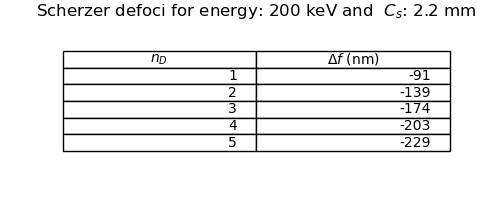

In [6]:
C_s = 2.2  # in mm 
acceleration_voltage = 200*1e3  # in eV

def calculate_scherzer(wavelength, C_s, order=1):
    """
    Calculate the Scherzer defocus. 
    
    Input:
    C_s: float - spherical aberration in mm (convention) will internally be scaled to Angstrom
    wavelength: float - wavelength in Angstrom
    order: int - optional the order of the Scherzer defocus
    
    Output:
    Scherzer defocus in Angstrom
    """
    C_s = C_s*1e7 # now in nm
    scherzer= -np.sqrt((2*order-0.5) * C_s*wavelength) # in Angstrom   
    return scherzer

wavelength = ks.get_wavelength(acceleration_voltage)

Scherzer_defoci = np.zeros([5,2])
Scherzer_defoci[:,0] = np.arange(5)+1  # the n_D values of order of Scherzer defocus

for n_D in Scherzer_defoci[:,0]:
    
    Scherzer_defoci[int(n_D-1),1] = calculate_scherzer(wavelength, C_s, order=n_D)/10 # Scherzer defocii in nm
Scherzer_defoci = np.array(np.round(Scherzer_defoci,0), dtype=int)

plt.figure(figsize=(5,2))
plt.title(f'Scherzer defoci for energy: {acceleration_voltage/1000:.0f} keV and  $C_s$: {C_s:.1f} mm' )
collabel=("$n_D$", "$\Delta f$ (nm)")
plt.axis('tight')
plt.axis('off')
the_table = plt.table(cellText=Scherzer_defoci, colLabels=collabel, loc='center')


Go to [Contrast transfer function](#Contrast-transfer-function) to see the effect on the image contrast of defocus.

## Point Resolution

The point resolution of a microscope is defined as the spatial frequency ''u''<sub>res</sub> 
where the CTF crosses the abscissa for the first time. At Scherzer defocus this value is maximized:

$$u_\text{res}(\text{Scherzer})=0.6\lambda^{3/4} C_s^{1/4}$$

Contributions with a spatial frequency higher than the point resolution can be filtered out with an appropriate aperture leading to easily interpretable images at the cost of a lot of information lost.


In [7]:
# Calculate the resolution at Scherzer defocus, Cs is in mm, lambda is in nm
# The returned value is in nm
C_s = 2.2
def calculate_resolution_scherzer(wavelength, C_s):
    """
    Calculates the resolution at Scherzer defocus
    
    Input:
    wavelength: float - wavelength of electrons in Angstrom
    C_s: float - spherical aberration in mm (convention)
    
    Output:
    resolution: float - resolution at Scherzer in Angstrom
    """
    C_s = C_s*1e7 #  now in nm
    wavelength = wavelength 
    scherzerres=0.64 * wavelength**0.75 * C_s**0.25
    return scherzerres

scherzer = calculate_scherzer(wavelength, C_s)
scherzer_resolution = calculate_resolution_scherzer(wavelength, C_s)

print(f'Point resolution (at Scherzer focus) is {scherzer_resolution:.2f} Angstrom')

Point resolution (at Scherzer focus) is 2.76 Angstrom


## Contrast transfer function
Now we plot the CTF for Scherzer defocus for spatial frequencies $u$ (distances in k- or reciprocal space):
$$\chi(u)=\frac{\pi}{2}C_s\lambda^3u^4-\pi \Delta f \lambda u^2$$

>Please note that we will see the square of the CTF: CTF$^2$ in the intensity of the images.

In the code cell below change the value of ``defocus2`` by setting the order of Scherzer defocus $n_D$, or replace it by a random nuymber.

(0.0, 0.5)

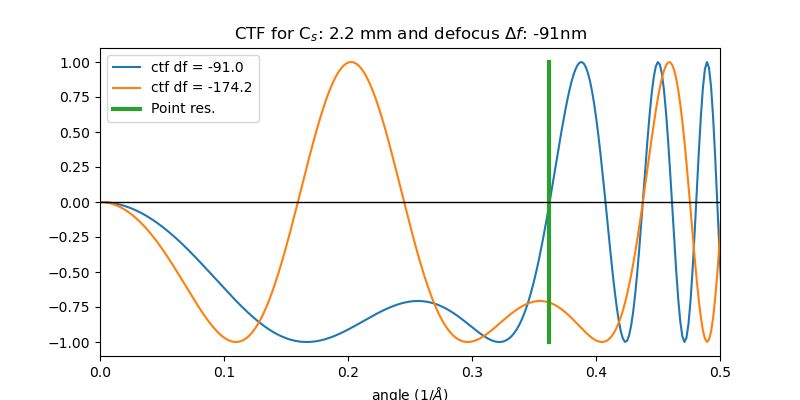

In [8]:
defocus2 = calculate_scherzer(wavelength, C_s, order=3)

defocus = scherzer = calculate_scherzer(wavelength, C_s)

wavelength = ks.get_wavelength(acceleration_voltage)
ref_scale_x = 0.016537397801242235/10
u = np.linspace(0,1023,1024)*ref_scale_x
def calculate_ctf(wavelength, C_s, defocus,k):
    # everything in Angstrom
    C_s = C_s*10**7
    ctf = np.sin(np.pi*defocus*wavelength * k**2 + 0.5*np.pi*C_s*wavelength**3 * k**4)
    return ctf


ctf = calculate_ctf(wavelength, C_s, defocus,u)
ctf2= calculate_ctf(wavelength, C_s, defocus2,u)

plt.figure(figsize=(8,4))
plt.title(f'CTF for C$_s$: {C_s:.1f} mm and defocus $\Delta f$: {defocus/10:.0f}nm')
plt.plot(u,ctf, label = f'ctf df = {defocus/10:.1f}')
plt.plot(u,ctf2, label = f'ctf df = {defocus2/10:.1f}')
plt.plot([1/scherzer_resolution,1/scherzer_resolution],[-1,1],linewidth = 3, label ='Point res.')
plt.plot([0,10],[0,0],linewidth = 1, c='black')
plt.xlabel('angle (1/$\AA$)')
plt.legend(loc=0)
plt.xlim(0,.5)

## The Diffractogram of an Amorphous Sample

First we define the aberration function chi $\chi$ by using above formula:

$$
\chi(\theta, \phi) = \sum_n \theta^{n+1} *\frac{1}{n+1} * \sum_{n} C_{n,m,a}  \cos(m*\phi) + C_{n,m,b} \sin(m*\phi) 
$$

In [9]:
def make_chi( phi, theta, aberrations)  :
    """
    ###
    # Aberration function chi 
    ###
    phi and theta are meshgrids of the angles in polar coordinates.
    aberrations is a dictionary with the aberrations coefficients 
    Attention: an empty aberrations dictionary will give you a perfect aberration
    """
    
    chi = np.zeros(theta.shape)
    for n in range(6):  ## First Sum up to fifth order
        term_first_sum = np.power(theta,n+1)/(n+1) # term in first sum
                
        second_sum = np.zeros(theta.shape)  ## second Sum intialized with zeros
        for m in range((n+1)%2,n+2, 2):
            #print(n, m)

            if  m >0: 
                if f'C{n}{m}a' not in aberrations: # Set non existent aberrations coefficient to zero
                    aberrations[f'C{n}{m}a'] = 0.
                if f'C{n}{m}b' not in aberrations:
                    aberrations[f'C{n}{m}b'] = 0.
                    
                # term in second sum
                second_sum = second_sum + aberrations[f'C{n}{m}a'] *np.cos(m* phi) + aberrations[f'C{n}{m}b'] *np.sin(m* phi)
            else:
                if f'C{n}{m}' not in aberrations: # Set non existent aberrations coefficient to zero
                    aberrations[f'C{n}{m}'] =  0.
                    
                # term in second sum
                second_sum = second_sum + aberrations[f'C{n}{m}']
        chi = chi + term_first_sum * second_sum *2*np.pi/ aberrations['wavelength']
        
    return chi


### Setting up angle and calculate aberration function
We set up all the angles over which we want to calculate the aberration function

In [10]:

def get_chi( ab, sizeX, sizeY, tags, verbose= False):      
    """
    ####
    # Internally reciprocal lattice vectors in 1/nm or rad.
    # All calculations of chi in angles.
    # All aberration coefficients in nm
    """
    ApAngle=ab['convergence_angle']/1000.0 # in rad

    wl = ks.get_wavelength(ab['acceleration_voltage'])
    if verbose:
        print(f"Acceleration voltage {ab['acceleration_voltage']/1000:}kV => wavelength {wl*1000.:.2f}pm")
              
    ab['wavelength'] = wl


    ## Reciprocal plane in 1/nm
    dk = 1/ab['FOV']
    kx = np.array(dk*(-sizeX/2.+ np.arange(sizeX)))
    ky = np.array(dk*(-sizeY/2.+ np.arange(sizeY)))
    Txv, Tyv = np.meshgrid(kx, ky)

    # define reciprocal plane in angles
    phi =  np.arctan2(Txv, Tyv)
    theta = np.arctan2(np.sqrt(Txv**2 + Tyv**2),1/wl)

    ## calculate chi 
    chi = (make_chi(phi,theta,ab))
    
    ## Aperture function 
    mask = theta >= ApAngle

    aperture =np.ones((sizeX,sizeY),dtype=float)
    aperture[mask] = 0.

    
    return chi, aperture



In [11]:
def print_abberrations(ab):
    from IPython.display import HTML, display
    output = '<html><body>'
    output+= f"Abberrations [nm] for acceleration voltage: {ab['acceleration_voltage']/1e3:.0f} kV"
    output+= '<table>'
    output+= f"<tr><td> C10 </td><td> {ab['C10']/10:.1f} </tr>"
    output+= f"<tr><td> C12a </td><td> {ab['C12a']/10:20.1f} <td> C12b </td><td> {ab['C12b']/10:20.1f} </tr>"
    output+= f"<tr><td> C21a </td><td> {ab['C21a']/10:.1f} <td> C21b </td><td> {ab['C21b']/10:.1f} "
    output+= f"    <td> C23a </td><td> {ab['C23a']/10:.1f} <td> C23b </td><td> {ab['C21b']/10:.1f} </tr>"
    output+= f"<tr><td> C30 </td><td> {ab['C30']/10:.1f} </tr>"
    output+= f"<tr><td> C32a </td><td> {ab['C32a']/10:20.1f} <td> C32b </td><td> {ab['C32b']/10:20.1f} "
    output+= f"<td> C34a </td><td> {ab['C34a']/10:20.1f} <td> C34b </td><td> {ab['C34b']/10:20.1f} </tr>"
    output+= f"<tr><td> C41a </td><td> {ab['C41a']/10:.3g} <td> C41b </td><td> {ab['C41b']/10:.3g} "
    output+= f"    <td> C43a </td><td> {ab['C43a']/10:.3g} <td> C43b </td><td> {ab['C41b']/10:.3g} </tr>"
    output+= f"<tr><td> C50 </td><td> {ab['C50']/10:.3g} </tr>"
    output+= f"<tr><td> Cc </td><td> {ab['Cc']/10:.3g} </tr>"

    output+='</table></body></html>'

    display(HTML(output))
    

### Define all aberration coefficients and paramters necessary 

In [12]:
ab = {'C10':0,'C12a':0,'C12b':0,'C21a':0,'C21b':0,'C23a':0,'C23b':0,'C30':0.,
                  'C32a':0.,'C32b':-0.,'C34a':0.,'C34b':0.,'C41a':0.,'C41b':-0.,'C43a':0.,
                  'C43b':-0.,'C45a':-0.,'C45b':-0.,'C50':0.,'C52a':-0.,'C52b':0.,
                  'C54a':-0.,'C54b':-0.,'C56a':-0.,'C56b':0.}
ab['C30'] = .5*1e7

ab['Cc'] = 2.0*1e7

ab['source_size'] = 2.0
ab['acceleration_voltage'] = 200000
ab['convergence_angle'] = 10

ab['origin'] = 'target aberrations'
ab['TEM_name'] = 'ZeissMC200'
ab_zero = ab.copy()
sizeX = sizeY = 512

sigma = 6 ## carbon

### Calculate Diffractogram

Let's assume a completely random object then the excit wave function will be also random, we weight those  random wave vectors according to the interaction parameter in an exponential function as before. So, we got us a transmission function and an exit wave $q_r$

Acceleration voltage 200.0kV => wavelength 25.08pm


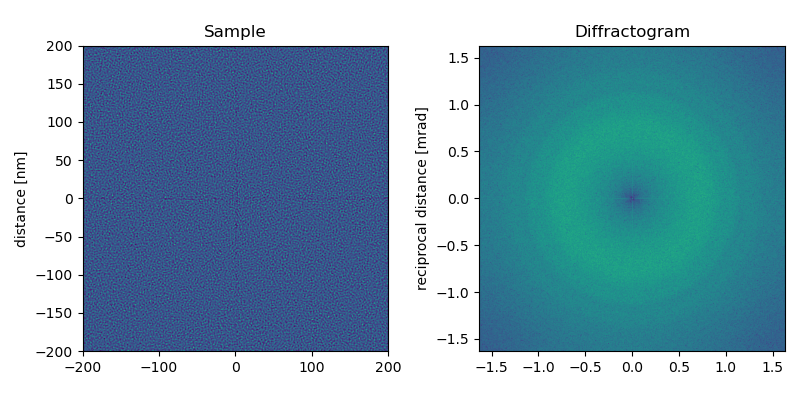

In [16]:
ab =  ab_zero.copy()
ab['C10'] = 40 # calculate_scherzer(wavelength, C_s, order=1)
ab['C12b'] = 0
ab['FOV'] = 400
ab['convergence_angle'] = 40 # in mrad

V_noise  =np.random.rand(sizeX,sizeY)
smoothing = 1
phi_r = ndimage.gaussian_filter(V_noise, sigma=(smoothing, smoothing), order=0)
q_r = np.exp(1j*sigma * phi_r)
Q_k = np.fft.fftshift(np.fft.ifft2(q_r))

chi, A_k  = get_chi( ab, sizeX, sizeY, ab, verbose= True)
T_k =  (np.exp(-1j*chi))
t_r = (np.fft.ifft2(np.fft.fftshift(T_k)))

psi_r =  np.fft.fftshift(np.fft.ifft2((Q_k*T_k)))

i_r  = np.real(psi_r*np.conjugate(psi_r))
diffractogram_k = np.absolute(np.fft.fftshift(np.fft.ifft2(i_r)))


fig, ax = plt.subplots(1, 2, figsize=(8, 4))
extent = [-int(ab['FOV']/2),int(ab['FOV']/2),-int(ab['FOV']/2),int(ab['FOV']/2)]
ax[0].imshow(i_r, extent = [-int(ab['FOV']/2),int(ab['FOV']/2),-int(ab['FOV']/2),int(ab['FOV']/2)])
ax[0].set_ylabel('distance [nm]')
ax[0].set_title('Sample')
extent_ff = 1/np.array(extent)*sizeX/(np.pi/2)
ax[1].imshow(np.log2(diffractogram_k), extent = extent_ff)
ax[1].set_ylabel("reciprocal distance [mrad]")
ax[1].set_title('Diffractogram')
scherzer_angle = 1/scherzer_resolution * wavelength *1000.
from matplotlib.patches import Circle
point_resolution = Circle((0, 0),radius = scherzer_angle, linestyle=':', fill = False, color = 'red')
ax[1].add_patch(point_resolution)
plt.tight_layout();
print_abberrations(ab)


In [17]:
def diffractogram(ab):
    V_noise  =np.random.rand(sizeX,sizeY)
    smoothing = 1
    phi_r = ndimage.gaussian_filter(V_noise, sigma=(smoothing, smoothing), order=0)
    q_r = np.exp(1j*sigma * phi_r)
    Q_k = np.fft.fftshift(np.fft.ifft2(q_r))

    chi, A_k  = get_chi( ab, sizeX, sizeY, ab, verbose= True)
    T_k =  (np.exp(-1j*chi))
    t_r = (np.fft.ifft2(np.fft.fftshift(T_k)))

    psi_r =  np.fft.fftshift(np.fft.ifft2((Q_k*T_k)))

    i_r  = np.real(psi_r*np.conjugate(psi_r))
    diffractogram_k = np.absolute(np.fft.fftshift(np.fft.ifft2(i_r)))


    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    extent = [-int(ab['FOV']/2),int(ab['FOV']/2),-int(ab['FOV']/2),int(ab['FOV']/2)]
    ax[0].imshow(i_r, extent = [-int(ab['FOV']/2),int(ab['FOV']/2),-int(ab['FOV']/2),int(ab['FOV']/2)])
    ax[0].set_ylabel('distance [$\AA$]')
    ax[0].set_title('Sample')
    extent_ff = 1/np.array(extent)*sizeX/(np.pi/2)
    ax[1].imshow(np.log2(diffractogram_k), extent = extent_ff)
    ax[1].set_ylabel("reciprocal distance [mrad]")
    ax[1].set_title('Diffractogram')
    scherzer_angle = 1/scherzer_resolution * ab['wavelength'] *10000.
    
    point_resolution = Circle((0, 0),radius = scherzer_angle, linestyle=':', fill = False, color = 'red')
    ax[1].add_patch(point_resolution)
    plt.tight_layout();
    print_abberrations(ab)


Now we can explore the effect of astigmatism

Acceleration voltage 200.0kV => wavelength 25.08pm


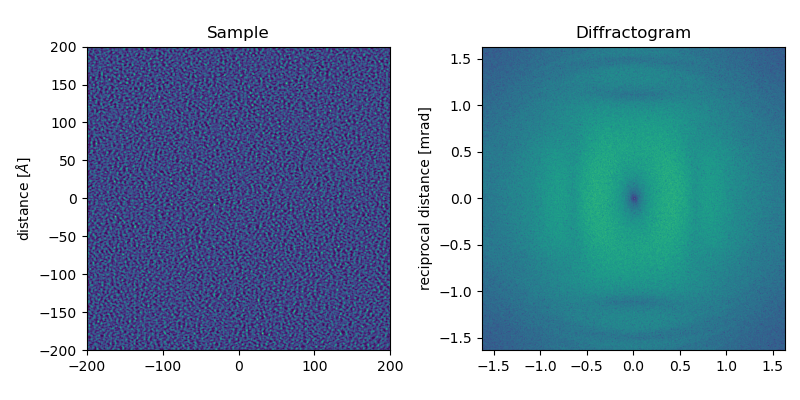

In [18]:
#All values in Angstrom
ab['C10'] = -500  
ab['C12a'] = 200
ab['C12b'] = 0
ab['FOV'] = 400

diffractogram(ab)

### Aberrations of a (Non-Corrected) TEM

We set typical values for our TEM (Zeiss Libbra 200MC)


In [19]:
acceleration_voltage_V = 200*1e3 # Microscope voltage in V
C_s = 2.2     # Spherical abberation coefficient in mm
defocus = -90 # Microscope defocus in nm
C_c = 2.0     # Chromatic abberation coefficient in mm

## Stability Parameters and Dampening of CTF

For stability, which is expressed as a dampening of the contrast transfer function. These envelope functions are determined by the following parameters.

Experimental parameters 
* chromatic aberration $C_c$ 
* energy spread of the electron gun
* convergence angle $\alpha$

Stability parameters
* stability of the acceleration voltage 
* stability of objective lens current
* driftrate fo the sample


In [20]:
IObj_stability = .1             # The objective lens stability in ppm (Delta I Obj/I Obj)*1e6

HT_stability = 0.1/200000*1e4   # The stabilty of the HT supply in ppm (Delta V/V)*1e6

source_spread = 0.6             # The energy spread of the electron source in eV. 
                                # FEG: 0.9 eV and LaB6: 2.0 eV are typical energy spread values for these emitters
source_alpha = 0.1             # The covergence semiangle of the source in mrad
                                # Note FEG and LaB6 buttons provide typical alpha value for these emitters
drift_rate = 1                # The drift rate in Angstrom/s. Note no exposure time is provided so 
                                # the Edrift envelope is for a 1s exposure.

However it is the ''envelope function'' ''E('''u''')'' which usually dampens the signal of beams 
scattered at high angles, and imposes a maximum to the transmitted spatial frequency. 
This maximum determines the highest resolution attainable with a microscope and is known as the information limit. 
''E('''u''')'' can be described as a product of single envelopes:

$$E(u)=E_s(u)E_c(u)E_d(u)$$
due to

* $E_s(u)$: source envelope
* $E_c(u)$: chromatic aberration
* $E_d(u)$: specimen drift

In principle we also should consider:
* $E_v(u)$: specimen vibration
* $E_D(u)$: detector
but we generally handle that by oversampling the image (an atom is more than a pixel)


Specimen drift and vibration can be minimized in a stable environment. It is usually the spherical aberration $C_s$ that limits spatial coherency and defines $E_s(u)$ and the chromatic aberration $C_c$, together with current and voltage instabilities that define the temporal coherency in $E_c(u)$. These two envelopes determine the information limit by damping the signal transfer in Fourier space with increasing spatial frequency $u$.

$$E_s(u) = \exp\left[-\left(\frac{\pi\alpha}{\lambda}\right)^2 \left(\frac{\delta\chi(u)}{\delta u}\right)^2\right] = \exp\left[-\left(\frac{\pi\alpha}{\lambda}\right)^2(C_s\lambda^3u^3+\Delta f\lambda u)^2\right]$$

where α is the semiangle of the pencil of rays illuminating the sample. Clearly, if the wave aberration ('here represented by ''C<sub>s</sub>'' and Δ''f'') vanished, this envelope function would be a constant one. In case of an uncorrected TEM with fixed ''C<sub>s</sub>'', the damping due to this envelope function can be minimized by optimizing the defocus at which the image is recorded (Lichte defocus).

The temporal envelope function can be expressed as

$$E_c(u) = \exp\left[-\frac{1}{2}\left(\pi\lambda\delta\right)^2u^4\right]$$

Here, $\delta$ is the focal spread with the chromatic aberration $C_c$ as the parameter:

$$\delta = C_c\sqrt{4\left(\frac{\Delta I_\text{obj}}{I_\text{obj}}\right)^2 + \left(\frac{\Delta E}{V_\text{acc}}\right)^2 + \left(\frac{\Delta V_\text{acc}}{V_\text{acc}}\right)^2}$$

The terms $\Delta I_\text{obj}/I_\text{obj}$ and $\Delta V_\text{acc}/V_\text{acc}$ represent instabilities in of the total current in the magnetic lenses and the acceleration voltage. $\Delta E/V_\text{acc}$ is the energy spread of electrons emitted by the source.


Information limit is 2.08 Ang 


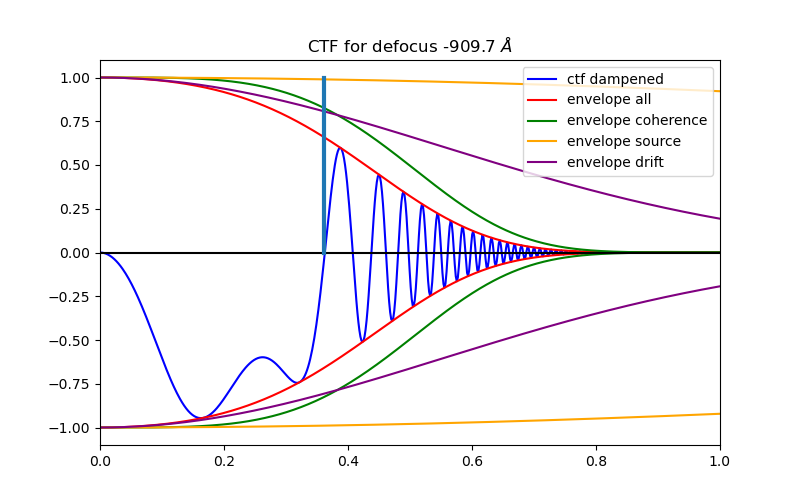

In [21]:
defocus= scherzer
C_c = 2.0

#Compute the Es function - source dependent envelope function
def source_Env(wavelength,source_alpha, defocus, Cs, k):
    alpha=source_alpha
    alpha=alpha/1e3 # convert mrads to rads
    var1=-1*((np.pi*alpha)/wavelength)**2
    EsEnv= np.exp(var1*(Cs*10*(wavelength)**3*k**3+defocus*wavelength*k)**2)
    return EsEnv


# Calculate the envelope component due to the chromatic aberration
def coherence_Env(IObj_stability, HT_stability, source_spread, Cc, voltage, wavelength, k):
    objstability = IObj_stability/1e6
    envelope_voltage = voltage #// in volts
    ht_stability = HT_stability/1e7 # in ppm
    source_energy_spread = source_spread  
    source_relative_energy_spread = source_energy_spread/envelope_voltage
    
    Cc=Cc*1e7 #// convert to nm
    delta=Cc*(4*(objstability)**2+(source_relative_energy_spread)**2+(ht_stability)**2)**0.5

    EcEnv=np.exp(-0.5*(np.pi*(wavelength)*delta)**2*k**4)

    return EcEnv


#Compute the drift envelope function
def drift_Env(drift_rate,k):
    drift=drift_rate
    edEnv=np.exp(-(1/6)*(np.pi*k*drift)**2)
    return edEnv

Env_source = source_Env(wavelength, source_alpha, defocus, C_s, u)
Env_coherence =  coherence_Env(IObj_stability, HT_stability, source_spread, C_c, acceleration_voltage_V, wavelength, u)
Env_drift = drift_Env(drift_rate, u)

Env_total = Env_source*Env_coherence*Env_drift
ctf = calculate_ctf(wavelength, C_s, defocus,u)


##Plot CTF and Envelope functions

plt.figure(figsize=(8,5))
plt.title(f'CTF for defocus {defocus:.1f} $\AA$')
#plt.plot(k,np.abs(ctf), label = f'ctf df = {defocus:.1f}')
plt.plot(u,(ctf*Env_total), c='blue', label = f'ctf dampened')
plt.plot(u,(Env_total), c='red', label = f'envelope all')
plt.plot(u,(-Env_total), c='red')
plt.plot(u,(Env_coherence), c='green', label = f'envelope coherence')
plt.plot(u,(-Env_coherence), c='green')
plt.plot(u,(Env_source), c='orange', label = f'envelope source')
plt.plot(u,(-Env_source), c='orange')
plt.plot(u,(Env_drift), c='purple', label = f'envelope drift')
plt.plot(u,(-Env_drift), c='purple')

plt.plot([0,20], [0,0], c='black')

plt.plot([1/scherzer_resolution,1/scherzer_resolution],[0,1],linewidth = 3)
plt.legend(loc=1)
plt.xlim(0,1)
#plt.ylim(0)

print(f'Information limit is {1/u[np.argmin(np.abs(Env_total-np.exp(-1)))]:.2f} Ang ')

The Diffractogram will give us the intensity and so we will get the squared of the CTF

Information limit is 2.08 Ang 


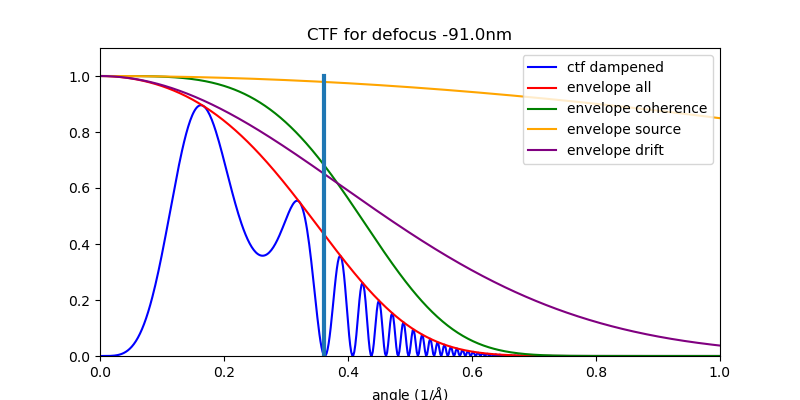

In [22]:
##Plot CTF and Envelope functions

plt.figure(figsize=(8,4))
plt.title(f'CTF for defocus {defocus/10 :.1f}nm')
#plt.plot(k,np.abs(ctf), label = f'ctf df = {defocus:.1f}')
plt.plot(u,(ctf*Env_total)**2,c='b', label = f'ctf dampened')
plt.plot(u,(Env_total)**2,c='r', label = f'envelope all')
plt.plot(u,(Env_coherence)**2,c='g', label = f'envelope coherence')
plt.plot(u,(Env_source)**2,c='orange', label = f'envelope source')
plt.plot(u,(Env_drift)**2, c='purple', label = f'envelope drift')

plt.plot([1/scherzer_resolution,1/scherzer_resolution],[0,1],linewidth = 3)
plt.xlabel('angle (1/$\AA$)')
plt.legend(loc=1)
plt.xlim(0,1)
plt.ylim(0,1.1)

print(f'Information limit is {1/u[np.argmin(np.abs(Env_total-np.exp(-1)))]:.2f} Ang ')

## Conclusion:
    
The contrast transfer function allows us to evaluate the resolution capabilities of a TEM. 

In the Zeiss Libra 200MC the point resolution is given by the relative high spherical aberration of $C_s = 2.2$mm.

The information limit is dominated by the energy spread of the electron source (which is excellent).

The diffractogram (Fourier Transform) of an amorphous sample allows to directly determine the aberrations:
- determine defocus and set
- correct astigmatism

These parameters are important for image interpretation and image simulations.  

## Navigation
- <font size = "3">  **Up Chapter 3: [Imaging](CH3_00-Imaging.ipynb)** </font>
- <font size = "3">  **Back: [Introduction to HRTEM](CH3_01-Resolution.ipynb)** </font>
- <font size = "3">  **Next: [Linear Image Approximation](CH3_04-Linear_Image_Approximation.ipynb)** </font>
- <font size = "3">  **List of Content: [Front](../_MSE672_Intro_TEM.ipynb)** </font>
